In [49]:
#4.1 Variation
#Putting other measures on top of 3.3 EWO Revision 2 without changing signals present

import pandas_datareader as pdr
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import dataframe_image as dfi
import seaborn as sns
from pylab import *

#EWO = Elliott Wave Oscillator, which is the difference between 5-day SMA and 35-day SMA
#The current code only focuses on the long position

target_market = 'SPY'
start_date = '1990-06-28'
end_date = '2022-06-28'

#lobf(x) function returns the slope of the line of best fit using OLS with input of pandas series
def lobf(x):
    line_fitter = LinearRegression()
    line_fitter.fit(np.array(x.index).reshape(-1 , 1), x.values)
    return line_fitter.coef_

sp500 = pdr.get_data_yahoo(target_market, start_date, end_date)
day = np.arange(1, len(sp500) + 1)
sp500['Day'] = day 
sp500['2-day'] = sp500['Close'].rolling(2).mean()   #Column for 5-day SMA
sp500['45-day'] = sp500['Close'].rolling(45).mean() #Column for 45-day SMA
sp500['50-day'] = sp500['Close'].rolling(50).mean() #Column for 50-day SMA
sp500['EWO'] = sp500['2-day'] - sp500['45-day']     #Column for EWO
sp500 = sp500[['Day', 'Open', 'Close', '2-day', '45-day', '50-day', 'EWO']]
sp500 = sp500.reset_index()
sp500 = sp500.set_index('Day')

#Check whether EWO of each day is over a certain positive value, 
#which is 1% of 5-day SMA(value 1 = Yes, value 0 = No)
sp500['Filter1'] = np.where(sp500['EWO'] > sp500['2-day']/100, 1, 0)

#Check whether the slope of the line of best fit corresponding to five most recent EWO values is positive
sp500['Filter2'] = np.where(sp500['EWO'].rolling(5).apply(lobf) > 0, 1, 0)

#Check whether the current price is in uptrend (i.e. over 100-day SMA)
sp500['Filter3'] = np.where(sp500['Close'] > sp500['50-day'], 1, 0)
sp500.dropna(inplace=True)

#Indicate where the 5-day EWO's slope is negative AND where the price is in downtrend
sp500['Exit1'] = np.where(sp500['EWO'].rolling(5).apply(lobf) < 0, -1, 0)
sp500['Exit2'] = np.where(sp500['Close'].rolling(125).apply(lobf) < 0, -1, 0)

condition1 = (sp500['Filter1'] == 1)
condition2 = (sp500['Filter2'] == 1)
condition3 = (sp500['Filter3'] == 1)

#sp500_buy dataframe refers to the buy signals, where all the filters are satistfied
sp500_buy = sp500.loc[condition1&condition2&condition3]

In [50]:
budget = 100000 # Initial Budget = 100,000 USD
buy_list = []
sell_list = []
sold_day = 0
bought_amount = 0

for i in range(len(list(sp500_buy.index))-1): #Iterate the elements in sp500_buy, which contains buy signals
    if (sold_day > list(sp500_buy.index)[i]+1):
        continue
    if bought_amount == 0:
        bought_day = list(sp500_buy.index)[i]+1 #Buy the stock at the next morning's open price
        buy_list.append(bought_day)
        bought_price = sp500.loc[bought_day, 'Open']
        bought_amount = budget // bought_price #Buy as many as the budget allows at that price
        budget -= bought_amount * bought_price #Remaining budget after having a long position

        print(int(bought_amount), "amount of S&P500 stock is bought at", \
              bought_price, "on", sp500.loc[bought_day, "Date"], "(Day", bought_day, ")")
        print(budget, "is the remaining budget")
    
    #Beginning from the day of long position until the subsequent day of a buy signal, 
    #check whether there's any exit sign; 
    #i.e. either the slope of EWO is negative or the stock price is in downtrend 

    for j in range(bought_day, sp500.iloc[[-1]].index[0]):
        if (sp500.loc[j, 'Exit1'] == -1) and (sp500.loc[j, 'Exit2'] == -1) or \
        (j == sp500.iloc[[-1]].index[0]-1):
            sold_price = sp500.loc[j+1, 'Open']
            sold_day = j+1
            sell_list.append(sold_day)
            budget += bought_amount * sold_price
            print(int(bought_amount), 'amount of S&P500 stock is sold at',
                  sold_price, 'on', sp500.loc[sold_day, "Date"], "(Day", sold_day, ")")
            print("After closing the position, current budget is", budget)
            print("\n")
            #Reset the parameter
            bought_amount = 0
            break
            

print("The final budget of EWO strategy is", round(budget), "USD")


#Calculate the final profit of the traditional Buy and Hold Strategy,
#started with the same budget and date
#bought_amount2 = 100000 // sp500.loc[55, 'Open']
#budget2 = 100000 - bought_amount2 * sp500.loc[55, 'Open']
#budget2 += bought_amount2 * sp500.loc[2212, 'Open']

#print('Buy and Hold resulted in the final budget of', budget2)

2213 amount of S&P500 stock is bought at 45.1875 on 1993-05-21 00:00:00 (Day 79 )
0.0625 is the remaining budget
2213 amount of S&P500 stock is sold at 44.578125 on 1994-04-15 00:00:00 (Day 307 )
After closing the position, current budget is 98651.453125


2167 amount of S&P500 stock is bought at 45.515625 on 1994-05-23 00:00:00 (Day 332 )
19.09375 is the remaining budget
2167 amount of S&P500 stock is sold at 45.984375 on 1994-06-09 00:00:00 (Day 344 )
After closing the position, current budget is 99667.234375


2141 amount of S&P500 stock is bought at 46.546875 on 1994-06-15 00:00:00 (Day 348 )
10.375 is the remaining budget
2141 amount of S&P500 stock is sold at 45.546875 on 1994-06-20 00:00:00 (Day 351 )
After closing the position, current budget is 97526.234375


2107 amount of S&P500 stock is bought at 46.28125 on 1994-08-02 00:00:00 (Day 381 )
11.640625 is the remaining budget
2107 amount of S&P500 stock is sold at 45.828125 on 1994-08-08 00:00:00 (Day 385 )
After closing the po

1744 amount of S&P500 stock is sold at 126.61000061035156 on 2006-07-11 00:00:00 (Day 3388 )
After closing the position, current budget is 220839.73849487305


1729 amount of S&P500 stock is bought at 127.66000366210938 on 2006-07-31 00:00:00 (Day 3402 )
115.5921630859375 is the remaining budget
1729 amount of S&P500 stock is sold at 128.17999267578125 on 2006-08-09 00:00:00 (Day 3409 )
After closing the position, current budget is 221738.79949951172


1714 amount of S&P500 stock is bought at 129.32000732421875 on 2006-08-16 00:00:00 (Day 3414 )
84.30694580078125 is the remaining budget
1714 amount of S&P500 stock is sold at 129.99000549316406 on 2006-08-24 00:00:00 (Day 3420 )
After closing the position, current budget is 222887.17636108398


1703 amount of S&P500 stock is bought at 130.8699951171875 on 2006-08-30 00:00:00 (Day 3424 )
15.574676513671875 is the remaining budget
1703 amount of S&P500 stock is sold at 130.0800018310547 on 2006-09-08 00:00:00 (Day 3430 )
After closing the

2263 amount of S&P500 stock is sold at 136.00999450683594 on 2012-07-10 00:00:00 (Day 4899 )
After closing the position, current budget is 307809.7670135498


2263 amount of S&P500 stock is bought at 135.97000122070312 on 2012-07-17 00:00:00 (Day 4904 )
109.65425109863281 is the remaining budget
2263 amount of S&P500 stock is sold at 135.19000244140625 on 2012-07-24 00:00:00 (Day 4909 )
After closing the position, current budget is 306044.629776001


2209 amount of S&P500 stock is bought at 138.52000427246094 on 2012-07-30 00:00:00 (Day 4913 )
53.940338134765625 is the remaining budget
2209 amount of S&P500 stock is sold at 138.55999755859375 on 2012-08-03 00:00:00 (Day 4917 )
After closing the position, current budget is 306132.97494506836


2183 amount of S&P500 stock is bought at 140.17999267578125 on 2012-08-07 00:00:00 (Day 4919 )
120.05093383789062 is the remaining budget
2183 amount of S&P500 stock is sold at 141.2899932861328 on 2012-08-14 00:00:00 (Day 4924 )
After closing the

In [51]:
sp500_buy = sp500.copy()
sp500_buy = sp500_buy.loc[buy_list]

sp500_sell = sp500.copy()
sp500_sell = sp500_sell.loc[sell_list]    

sp500_buy.info()
sp500_sell.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111 entries, 79 to 7340
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     111 non-null    datetime64[ns]
 1   Open     111 non-null    float64       
 2   Close    111 non-null    float64       
 3   2-day    111 non-null    float64       
 4   45-day   111 non-null    float64       
 5   50-day   111 non-null    float64       
 6   EWO      111 non-null    float64       
 7   Filter1  111 non-null    int64         
 8   Filter2  111 non-null    int64         
 9   Filter3  111 non-null    int64         
 10  Exit1    111 non-null    int64         
 11  Exit2    111 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(5)
memory usage: 11.3 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 111 entries, 307 to 7349
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----     

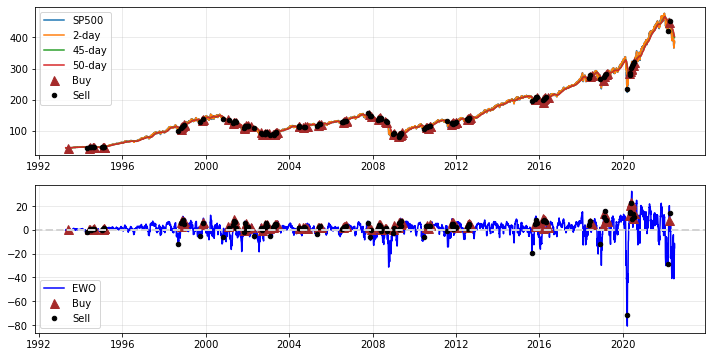

In [52]:
plt.rcParams['figure.figsize'] = 12, 6
 
plt.subplot(211) #Upper plot
plt.grid(True, alpha = .3)
plt.plot(sp500['Date'], sp500['Close'], label = 'SP500')
plt.plot(sp500['Date'], sp500['2-day'], label = '2-day')
plt.plot(sp500['Date'], sp500['45-day'], label = '45-day')
plt.plot(sp500['Date'], sp500['50-day'], label = '50-day')


plt.plot(sp500_buy['Date'], sp500_buy['Close'], '^',
         color = 'brown', label='Buy', markersize = 9)
plt.plot(sp500_sell['Date'], sp500_sell['Open'], '.',
         color = 'k', label='Sell', markersize = 9)
plt.legend(loc='upper left')

plt.subplot(212) #Lower plot; i.e. EWO 
plt.grid(True, alpha = .3)
plt.plot(sp500['Date'], sp500['EWO'], color='blue', label = 'EWO')
plt.plot(sp500_buy['Date'], sp500_buy['EWO'], '^',
         color = 'brown', label='Buy', markersize = 9)
plt.plot(sp500_sell['Date'], sp500_sell['EWO'], '.',
         color = 'k', label='Sell', markersize = 9)
plt.axhline(0, color='lightgray', linestyle='--', linewidth=2)
#plt.savefig('EWO Revision 2 Problem.png', dpi=500)
plt.legend(loc='lower left')